In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from PIL import Image
from sklearn.model_selection import train_test_split
from pathlib import Path
from typing import Tuple, List, Dict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.visualization import circuit_drawer
from qiskit_aer import AerSimulator
from qiskit import transpile

In [2]:
# Read the CSV files
meta_df = pd.read_csv("Meta.csv")
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

# Display basic information
print("Dataset information:")
print(f"Number of training samples: {len(train_df)}")
print(f"Number of test samples: {len(test_df)}")
print("\nMeta data sample:")
display(meta_df.head())

Dataset information:
Number of training samples: 39209
Number of test samples: 12630

Meta data sample:


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [4]:
def preprocess_image(image_path: str, size: tuple = (32, 32)) -> np.ndarray:
    # Preprocess image for quantum encoding.

    try:
        # Load and resize image
        image = Image.open(image_path)
        image = image.resize(size)
        
        # Convert to numpy array and normalize
        normalized = np.array(image) / 255.0
        
        # Flatten and combine RGB channels
        r = normalized[:,:,0].flatten()
        g = normalized[:,:,1].flatten()
        b = normalized[:,:,2].flatten()
        combined = np.concatenate([r, g, b])
        
        # Normalize for quantum amplitude encoding
        norm = np.sqrt(np.sum(combined**2))
        if norm > 0:
            normalized_amplitude = combined / norm
        else:
            normalized_amplitude = combined
            
        return normalized_amplitude
        
    except Exception as e:
        raise Exception(f"Error preprocessing image {image_path}: {str(e)}")

Sample path: Train/20/00020_00000_00000.png
Processed data shape: (3072,)
Data range: [0.012, 0.036]


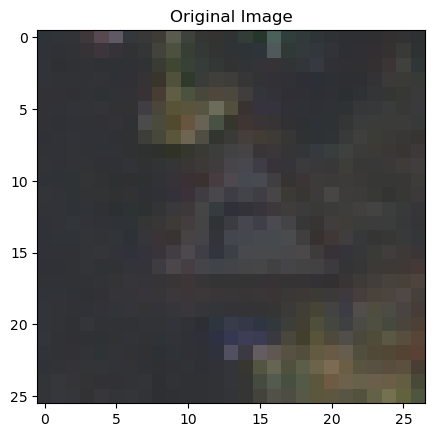

In [5]:
# Take first image from training set
sample_path = train_df['Path'].iloc[0]
sample_data = preprocess_image(sample_path)

print(f"Sample path: {sample_path}")
print(f"Processed data shape: {sample_data.shape}")
print(f"Data range: [{sample_data.min():.3f}, {sample_data.max():.3f}]")

# Display original image
plt.figure(figsize=(5, 5))
plt.imshow(Image.open(sample_path))
plt.title("Original Image")
plt.show()

In [6]:
# Create quantum circuit for encoding
num_qubits = 12  # log2(3072) ≈ 12
qr = QuantumRegister(num_qubits, 'q')
cr = ClassicalRegister(num_qubits, 'c')
circuit = QuantumCircuit(qr, cr)

# Apply initial Hadamard gates
circuit.h(qr)

# Encode amplitudes using controlled rotations
for i in range(min(len(sample_data), 2**num_qubits)):
    if abs(sample_data[i]) > 1e-10:
        binary = format(i, f'0{num_qubits}b')
        
        # Apply X gates for control qubits
        for j, bit in enumerate(binary):
            if bit == '1':
                circuit.x(qr[j])
        
        # Calculate rotation angle
        angle = 2 * np.arccos(np.sqrt(abs(sample_data[i]))) if sample_data[i] > 0 else 0
        
        # Multi-controlled rotation
        if num_qubits > 1:
            circuit.mcry(
                theta=angle,
                q_controls=[qr[j] for j in range(num_qubits-1)],
                q_target=qr[-1]
            )
        else:
            circuit.ry(angle, qr[0])
        
        # Uncompute X gates
        for j, bit in enumerate(binary):
            if bit == '1':
                circuit.x(qr[j])

#  Apply measurement gates
circuit.barrier()
circuit.measure(qr, cr)

/opt/anaconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [7]:
print(f"Number of qubits: {circuit.num_qubits}")
print(f"Number of gates: {circuit.size()}")
print(f"Depth of the circuit: {circuit.depth()}")

Number of qubits: 12
Number of gates: 59416
Depth of the circuit: 27650


In [8]:
# Create a smaller circuit with only a few gates
partial_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
for instruction in circuit.data[:10]:  # Change 10 to a suitable number based on performance
    operation = instruction.operation
    qubits = instruction.qubits
    clbits = instruction.clbits
    partial_circuit.append(operation, qubits, clbits)

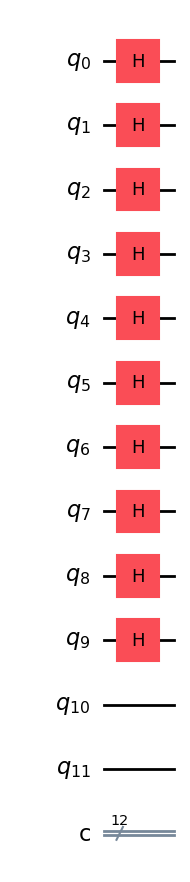

In [9]:
# Visualize the partial circuit
display(partial_circuit.draw(output="mpl"))

In [10]:
# Get the state vector of the smaller circuit
state_vector = Statevector.from_instruction(partial_circuit)
print(f"Number of amplitudes in the smaller circuit state vector: {len(state_vector)}")

Number of amplitudes in the smaller circuit state vector: 4096


In [11]:
# Add measurement operations to all qubits
partial_circuit.measure_all()
# Use Aer simulator to sample the outcomes
backend = AerSimulator()

# Compile and simulate the smaller circuit
compiled_partial = transpile(partial_circuit, backend, optimization_level=3)
job = backend.run(compiled_partial, shots=256)
result = job.result()
counts = result.get_counts(compiled_partial)
print("Measurement outcome counts (partial circuit):", counts)

Measurement outcome counts (partial circuit): {'000011101000 000000000000': 1, '000100110001 000000000000': 1, '001000111010 000000000000': 1, '001001101001 000000000000': 1, '001111110101 000000000000': 1, '001111110110 000000000000': 1, '000011100000 000000000000': 1, '000100111001 000000000000': 1, '000001011001 000000000000': 1, '001000101100 000000000000': 1, '001100110111 000000000000': 1, '000111000011 000000000000': 1, '000000100101 000000000000': 1, '001100101110 000000000000': 1, '000010101100 000000000000': 1, '001110111110 000000000000': 1, '000001001011 000000000000': 1, '001100011101 000000000000': 1, '000100011111 000000000000': 1, '001111000101 000000000000': 1, '000001100110 000000000000': 1, '000011001110 000000000000': 1, '000000011111 000000000000': 1, '000000111000 000000000000': 2, '001100001100 000000000000': 1, '001011101100 000000000000': 1, '001010101101 000000000000': 1, '000111010111 000000000000': 1, '001111101001 000000000000': 1, '001011111101 00000000000

In [12]:
# Function to prepare batches
def prepare_batch(df: pd.DataFrame, batch_size: int = 32) -> Tuple[List[np.ndarray], np.ndarray]:
    # Prepare a batch of images for quantum encoding.
    
    processed_images = []
    
    # Process images in batches
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_images = [preprocess_image(path) for path in batch_df['Path']]
        processed_images.extend(batch_images)
    
    return processed_images, df['ClassId'].values

# Test batch processing with a small batch
sample_batch, sample_labels = prepare_batch(train_df.head(), batch_size=5)
print(f"Processed {len(sample_batch)} images")
print(f"Labels: {sample_labels}")

Processed 5 images
Labels: [20 20 20 20 20]


In [13]:
print(f"Number of qubits in the circuit: {partial_circuit.num_qubits}")

Number of qubits in the circuit: 12
